# Cerebral Stroke Prediction-Imbalanced Dataset
Testing the use of the Principal Component Analysis (PCA) technique for anomaly detection on the [Stroke Prediction](https://www.kaggle.com/datasets/shashwatwork/cerebral-stroke-predictionimbalaced-dataset) dataset from Kaggle.

Anomalies, which deviate from the normal data pattern, will then be revealed as points that project far from the core of the data in this reduced space. In other words, the core idea behind anomaly detection with PCA is that normal data points will be close to their reconstructed values in the original space, while anomalous points will exhibit larger reconstruction errors. 


## WorkFlow

**Preprocessing**

- Drop duplicates
- Impute numerical variables with median
- Impute categorical variables with the mode or "most frequent"
    - Impute "smoking_status" with "unknown" --> Due to the large number of missing values.
- Scale numerical variables
- OneHotEncode categorical variables

**Modelling**

- Apply PCA
    - Visualize data in reduced space
- Reconstruct Data
    - Calculate Information loss
    - Define threshold and find anomalies.

In [32]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

## Data Loading and Preprocessing

In [2]:
raw_data = pd.read_csv("./data/dataset.csv")
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


In [3]:
raw_data.head(4)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0


In [4]:
# Checking for duplicates
raw_data.duplicated().sum()

np.int64(0)

In [5]:
# Checking for missing data
raw_data.isna().sum()

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [6]:
y = raw_data.stroke
data = raw_data.drop(columns=["stroke", "id"]).copy()

In [7]:
y.value_counts()

stroke
0    42617
1      783
Name: count, dtype: int64

The data is heavily imbalanced. The positive class "1" only represents 1.8% of the data.

In [8]:
object_columns = list(data.select_dtypes('object').columns)
numerical_columns = list(
    data.columns[~data.columns.isin(object_columns)]
)

print('object_columns', object_columns)
print('numerical_columns', numerical_columns)

object_columns ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numerical_columns ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']


In [ ]:
# Printing the values for all the categorical columns

for col in object_columns:
    print(data[col].value_counts(), "\n\n")

gender
Female    25665
Male      17724
Other        11
Name: count, dtype: int64 


ever_married
Yes    27938
No     15462
Name: count, dtype: int64 


work_type
Private          24834
Self-employed     6793
children          6156
Govt_job          5440
Never_worked       177
Name: count, dtype: int64 


Residence_type
Urban    21756
Rural    21644
Name: count, dtype: int64 


smoking_status
never smoked       16053
formerly smoked     7493
smokes              6562
Name: count, dtype: int64 




## Modelling

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [10]:
def fit_transform(data):
    data = data.copy()

    data.drop_duplicates()

    data["smoking_status"] = data["smoking_status"].fillna("Unknown")

    num_pipe = Pipeline(
        steps=[
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler()),
        ]
    )

    cat_pipe = Pipeline(
        steps=[
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("scale", OneHotEncoder()),
        ]
    )

    pipe = ColumnTransformer(
        [
            ("num", num_pipe, numerical_columns),
            ("cat", cat_pipe, object_columns),
        ],
        remainder="passthrough"
    )
    # drop
    data = pipe.fit_transform(data)
    return data, pipe

In [11]:
normal_data = data[y==0]
anomaly_data = data[y==1]

We apply data imputation and scaling on a single pipeline. `fit_transform` is used for the normal data, while `transform` for the anomaly data.

In [12]:
processed_normal_data, pipe = fit_transform(normal_data)
processed_normal_data = pd.DataFrame(
    processed_normal_data,
    index=normal_data.index
)

processed_anomaly_data = pd.DataFrame(
    pipe.transform(anomaly_data),
    index=anomaly_data.index
)
print(processed_normal_data.shape, processed_anomaly_data.shape)

(42617, 21) (783, 21)


### Principal Component Analysis

**Dimensionality Reduction:** PCA transforms high-dimensional data into a lower-dimensional space while preserving the most significant variance. This process creates principal components, which are linear combinations of the original features that capture the most variance in the data. 

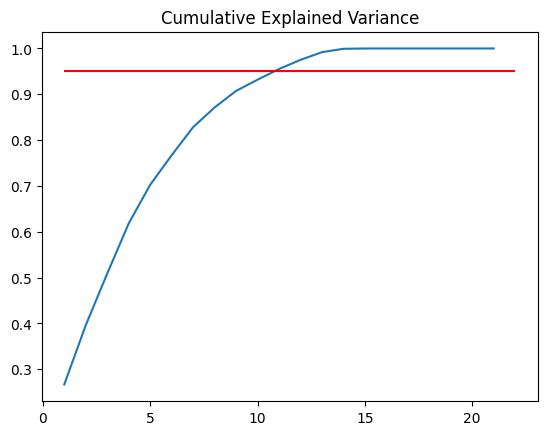

In [13]:
pca0 = PCA(random_state=30)

pca0.fit(processed_normal_data)
components = range(1, processed_normal_data.shape[1] + 1)

plt.figure()
plt.plot(
    components,
    pca0.explained_variance_ratio_.cumsum()
)
plt.hlines(0.95, 1, processed_normal_data.shape[1] + 1, 'r')
plt.title("Cumulative Explained Variance")
plt.show()

We compute the lower dimension space using the normal data via `fit_transform` and then apply the transformations to the anomaly data via `transform`.

Let's keep the 95% of the variance and plot a **projection of the normal Data Projected Onto the first and second principal components**.

pca_normal_data.shape=(42617, 11)


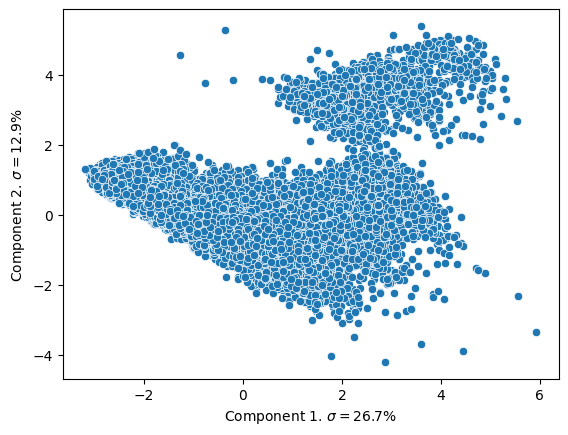

In [14]:
### Keeping 95% variance

pca = PCA(0.95, random_state=30)

pca_normal_data = pd.DataFrame(
    pca.fit_transform(processed_normal_data),
    index=processed_normal_data.index
)

print(f"{pca_normal_data.shape=}")

plt.figure()
ax = sns.scatterplot(x=pca_normal_data[0],
                     y=pca_normal_data[1])
plt.xlabel(f"Component 1. $\sigma=${pca.explained_variance_ratio_[0]:.1%}")
plt.ylabel(f"Component 2. $\sigma=${pca.explained_variance_ratio_[1]:.1%}")

plt.show()

In [15]:
# Transforming anomalies to reduced dimension
pca_anomalies = pd.DataFrame(
    pca.transform(processed_anomaly_data),
    index=processed_anomaly_data.index
)

### Data Reconstruction
**Identifying Anomalies:**
Anomalies are identified by measuring the distance between the original data points and their projections in the lower-dimensional space. Points with large reconstruction errors or distances are flagged as potential anomalies.

In [16]:
### Reconstructing the data
restored_normal = pd.DataFrame(
    pca.inverse_transform(pca_normal_data),
    index=pca_normal_data.index
)

restored_anomalies = pd.DataFrame(
    pca.inverse_transform(pca_anomalies),
    index=pca_anomalies.index
)

In [17]:
def information_loss_metric(original_data, transformed_data):
    loss = np.sum(
        (np.array(original_data) - np.array(transformed_data))**2,
        axis=1
    )
    loss = pd.Series(data=loss, index=original_data.index)
    return loss

In [21]:
normal_data_scores = information_loss_metric(processed_normal_data,
                                        restored_normal)
anomalous_data_scores = information_loss_metric(processed_anomaly_data,
                                         restored_anomalies)
print(f"{normal_data_scores.shape[0]=}, {anomalous_data_scores.shape[0]=}")

normal_data_scores.shape[0]=42617, anomalous_data_scores.shape[0]=783


The reconstruction error of normal data should be relatively uniform and significantly lower than that of anomalies. See plot below.

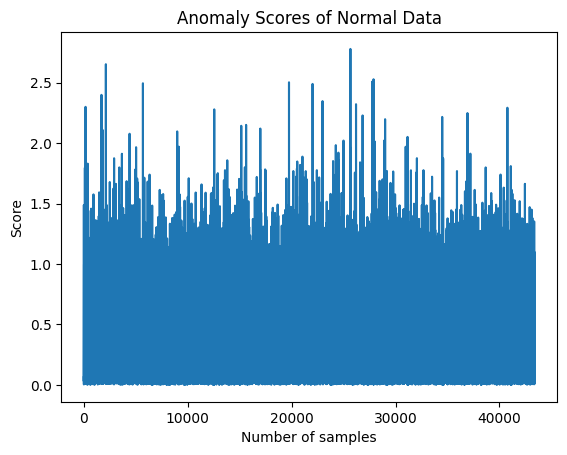

In [22]:
plt.figure()
normal_data_scores.plot(title='Anomaly Scores of Normal Data')
plt.ylabel("Score")
plt.xlabel("Number of samples")
plt.show()

Let's plot the anomaly reconstruction error.

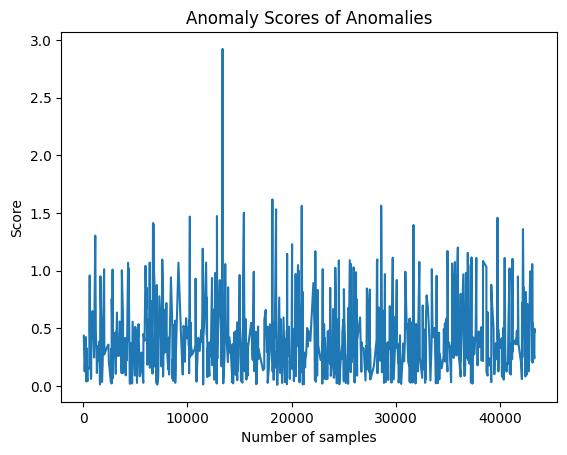

In [24]:
plt.figure()
anomalous_data_scores.plot(title='Anomaly Scores of Anomalies')
plt.ylabel("Score")
plt.xlabel("Number of samples")
plt.show()

Unfortunately, the average reconstruction error of the normal data is twice as high as that of the anomalies. This means that, for this particular dataset, the PCA technique is not well suited for anomaly detection.

Let's calculate the confusion matrix for the sake of completeness.

In [25]:
anomaly_scores = pd.concat(
    [normal_data_scores, anomalous_data_scores], ignore_index=False, sort=True
)

In [26]:
results_df = pd.DataFrame(anomaly_scores, columns=["anomaly_score"])
results_df["original_label"] = y.copy()

We typically use the mean value as a threshold to separate the normal from the anomalies. In this case, however, we see the values are so close that it will make class separation difficult or imposible in this space.

In [27]:
results_df.groupby("original_label")["anomaly_score"].describe()

,count,mean,std,min,25%,50%,75%,max
original_label,,,,,,,,
0,42617.0,0.348421,0.332175,0.000041,0.072962,0.262834,0.524259,2.778943
1,783.0,0.407207,0.330251,0.007653,0.175303,0.347146,0.520851,2.923613


Setting a threshold value of 0.5.
- Anything below is considered normal data.
- Anything above is considered an anomaly.

In [28]:
# Play around with the threshold
threshold = 0.5

results_df["Y_pred"] = (results_df.anomaly_score > threshold).astype(int)
results_df

,anomaly_score,original_label,Y_pred
0,0.063659,0,0
1,0.031501,0,0
2,0.420205,0,0
3,0.394662,0,0
4,1.488235,0,1
...,...,...,...
43148,0.541584,1,1
43268,0.271196,1,0
43304,0.237504,1,0
43318,0.495011,1,0


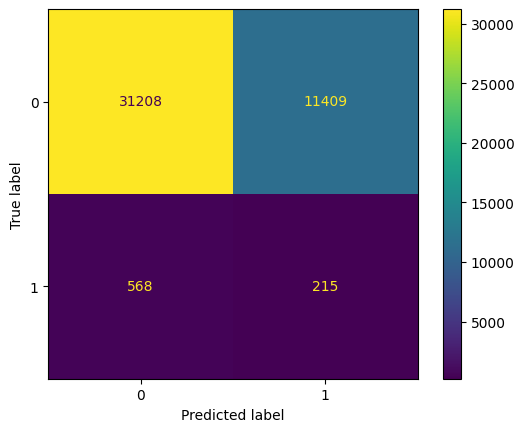

In [30]:
disp = ConfusionMatrixDisplay(
    confusion_matrix(results_df.original_label, results_df.Y_pred),
)

disp.plot()

In [31]:
from sklearn.metrics import classification_report


print(classification_report(results_df.original_label, results_df.Y_pred))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84     42617
           1       0.02      0.27      0.03       783

    accuracy                           0.72     43400
   macro avg       0.50      0.50      0.44     43400
weighted avg       0.96      0.72      0.82     43400



An accuracy of 0.72 is just expected because we are dealing with heavily imbalance data. It does not truly reflect our models performance.
- We see an excesive number of false positives (resulting in a positive class precision of 0.02).
    - This just proves that either the preprocessing pipeline or the PCA method is not suitable for anomaly detection in this particular dataset.
- Lastly, there is a clear trade-off between the number of false positives and false negatives as we adjust the threshold to identify stroke based on the anomaly score. The results indicate that PCA is not an adequate option for this use case.